# Orders Analysis

First we'll focus on the orders side of the data to analyze what elements are associated with a particular review score.

To do this, we'll create a single data table with **all unique orders as index and all properties of these orders as columns.**

In [3]:
# Auto reload imported module everytime a jupyter cell is executed (handy for olist.order.py updates)
%load_ext autoreload
%autoreload 2

In [4]:
# Import usual modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Import olist data
from olist.data import Olist
olist=Olist()
data=olist.get_data()

## Preparing Orders-related Data

Implement methods to help prepare orders-related data for statistical modeling and analysis

### get_wait_time( )

Implement a method that returns a dataframe with **'order_id', 'wait_time', 'expected_wait_time', 'delay_vs_expected',** and **'order_status'**

In [6]:
# make copy and inspect orders data
orders = data['orders'].copy()
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [7]:
# inspecting for any any null values
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [8]:
#Converting columns with timestamps to datetime data type
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

In [9]:
# Calculate number of days in each time_delta
one_day_delta = np.timedelta64(24, 'h')

# Assign and compute 'wait_time', 'delay_vs_expected', and 'expected_wait_time'

# wait_time = length of time calculated from customer ordering online until receiving delivery
orders.loc[:,'wait_time'] = \
    (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']) / one_day_delta

# delay_vs_expected = negative value only if order arrived later than expected
orders.loc[:,'delay_vs_expected'] = \
    (orders['order_estimated_delivery_date'] - orders['order_delivered_customer_date']) / one_day_delta

# expected_wait_time = how much time the customer has been told to wait before receiving order    
orders.loc[:,'expected_wait_time'] = \
    (orders['order_estimated_delivery_date'] - orders['order_purchase_timestamp']) / one_day_delta

In [10]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,wait_time,delay_vs_expected,expected_wait_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.436574,7.107488,15.544063
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,13.782037,5.355729,19.137766
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.394213,17.245498,26.639711
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13.208750,12.980069,26.188819
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2.873877,9.238171,12.112049


In [11]:
# When 'delay_vs_expected' is negative, then delivery was later than expected. This causes customer dissatisfaction.
# If positive, then can safely ignore.
def handle_delay(x):
    if x < 0:
        return abs(x)
    else:
        return 0

# revise 'delay_vs_expected' to only show length of delay in days (if any) 
orders.loc[:,'delay_vs_expected'] = orders['delay_vs_expected'].apply(handle_delay)

In [12]:
# Double-check to see if newly created columns are calculated as expected
orders[['order_id', 'wait_time', 'expected_wait_time', 'delay_vs_expected']].tail(10)

,order_id,wait_time,expected_wait_time,delay_vs_expected
99431,b0f4af5c1b06e24fef510703bfe9f0a6,14.108588,25.360417,0.000000
99432,cfa78b997e329a5295b4ee6972c02979,37.244826,28.588414,8.656412
99433,9115830be804184b91f5c00f6f49f92d,16.019537,33.168322,0.000000
99434,aa04ef5214580b06b10e2a378300db44,11.531505,48.979132,0.000000
99435,880675dff2150932f1601e1c07eadeeb,11.085370,26.621389,0.000000
99436,9c5dedf39a927c1b2549525ed64a053c,8.218009,18.587442,0.000000
99437,63943bddc261676b46f01ca7ac2f7bd8,22.193727,23.459051,0.000000
99438,83c1379a015df1e13d02aae0204711ab,24.859421,30.384225,0.000000
99439,11c177c8e97725db2631073c19f07b62,17.086424,37.105243,0.000000
99440,66dea50a8b16d9b4dee7af250b4be1a5,7.674306,25.126736,0.000000


In [13]:
# Double-check if get_wait_time() method functioning properly
from olist.order import Order
Order().get_wait_time().head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered


### get_review_score( )

Implement a method that will return a dataframe with the columns **'order_id', 'dim_is_five_star', 'dim_is_one_star',** and **'review_score'**

In [14]:
# make copy and inspect reviews data
reviews = data['order_reviews'].copy()
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [15]:
# create functions for one-hot encoding of review_score. Only focusing on scores of 1-star or 5-stars.
def dim_five_star(d):
    if d == 5:
        return 1
    else:
        return 0

def dim_one_star(d):
    if d == 1:
        return 1
    else:
        return 0

In [16]:
reviews["dim_is_five_star"] = reviews["review_score"].map(dim_five_star) # --> Series([0, 1, 1, 0, 0, 1 ...])

reviews["dim_is_one_star"] = reviews["review_score"].map(dim_one_star) # --> Series([0, 1, 1, 0, 0, 1 ...])

In [17]:
reviews[["order_id", "dim_is_five_star", "dim_is_one_star", "review_score"]].head(10)

,order_id,dim_is_five_star,dim_is_one_star,review_score
0,73fc7af87114b39712e6da79b0a377eb,0,0,4
1,a548910a1c6147796b98fdf73dbeba33,1,0,5
2,f9e4b658b201a9f2ecdecbb34bed034b,1,0,5
3,658677c97b385a9be170737859d3511b,1,0,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,1,0,5
5,b18dcdf73be66366873cd26c5724d1dc,0,1,1
6,e48aa0d2dcec3a2e87348811bcfdf22b,1,0,5
7,c31a859e34e3adac22f376954e19b39d,1,0,5
8,9c214ac970e84273583ab523dfafd09b,1,0,5
9,b9bf720beb4ab3728760088589c62129,0,0,4


In [18]:
# Double-check if get_review_score() method functioning properly
Order().get_review_score().head()

,order_id,dim_is_five_star,dim_is_one_star,review_score
0,73fc7af87114b39712e6da79b0a377eb,0,0,4
1,a548910a1c6147796b98fdf73dbeba33,1,0,5
2,f9e4b658b201a9f2ecdecbb34bed034b,1,0,5
3,658677c97b385a9be170737859d3511b,1,0,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,1,0,5


### get_number_of_products( )

Implement a method that will return a dataframe with the columns **'order_id'** and **'number_of_products'** (total number of products per order)

In [19]:
data["order_items"].groupby("order_id").count()\
.rename(columns={"order_item_id": "number_of_products"})\
.sort_values("number_of_products")[['number_of_products']]

,number_of_products
order_id,
00010242fe8c5a6d1ba2dd792cb16214,1
a6e9d106235bcf1dda54253686d89e99,1
a6e9b80a7636eb8dd592dbb3e20d0a91,1
a6e963c11e80432334e984ead4797a8b,1
a6e8ad5db31e71f5f12671af561acb4a,1
...,...
428a2f660dc84138d969ccd69a0ab6d5,15
9ef13efd6949e4573a18964dd1bbe7f5,15
1b15974a0141d54e36626dca3fdc731a,20


In [20]:
# Double-check if get_number_products() method functioning properly
Order().get_number_products().head()

,order_id,number_of_products
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1


### get_number_of_sellers( )

Implement a method that will return a dataframe with the columns **'order_id'** and **'number_of_seller'** (total number of unique sellers per order)

In [21]:
sellers = \
    data['order_items']\
    .groupby('order_id')['seller_id'].nunique().reset_index()

sellers.columns = ['order_id', 'number_of_sellers']
sellers.sort_values('number_of_sellers')

,order_id,number_of_sellers
0,00010242fe8c5a6d1ba2dd792cb16214,1
65559,aaaf314a8cf0d0da71e52c6cd4184cbd,1
65558,aaaea350ff8a957595f3c631d6b63d1b,1
65557,aaae80f5b6239bd9e1b22e9aa542c3e8,1
65556,aaabf43feb9498d9de4588eb73231c25,1
...,...,...
11231,1d23106803c48c391366ff224513fb7f,4
53796,8c2b13adf3f377c8f2b06b04321b0925,4
55847,91be51c856a90d7efe86cf9d082d6ae3,4
79967,cf5c8d9f52807cb2d2f0a0ff54c478da,5


In [22]:
# Double-check if get_number_sellers() method functioning properly
Order().get_number_sellers().head()

,order_id,number_of_sellers
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1


### get_price_and_freight( )

Implement a method that will return a dataframe with the columns **'order_id', 'price',** and **'freight_value'**

In [23]:
price_freight = \
    data['order_items']\
    .groupby('order_id',
             as_index=False).agg({'price': 'sum',
                                  'freight_value': 'sum'})

In [24]:
# Double-check if get_price_and_freight() method functioning properly
Order().get_price_and_freight().head()

,order_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14


## Inspect Features

Analyze features from Orders dataset by looking at distributions and correlations

In [25]:
# Get summary stats for each column
orders = Order().get_training_data()
orders.describe()

,wait_time,expected_wait_time,delay_vs_expected,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value
count,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000
mean,12.564574,23.747123,0.774420,0.589061,0.100539,4.142237,1.142598,1.013968,136.895781,22.780658
std,9.542359,8.762100,4.747827,0.492007,0.300719,1.296559,0.540014,0.123772,208.701803,21.532648
min,0.533414,2.008009,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.850000,0.000000
25%,6.771296,18.337187,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000,45.900000,13.850000
50%,10.225243,23.235741,0.000000,1.000000,0.000000,5.000000,1.000000,1.000000,86.000000,17.170000
75%,15.732506,28.416094,0.000000,1.000000,0.000000,5.000000,1.000000,1.000000,149.900000,24.020000
max,209.628611,155.135463,188.975081,1.000000,1.000000,5.000000,21.000000,5.000000,13440.000000,1794.960000


In [27]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97007 entries, 0 to 97014
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            97007 non-null  object 
 1   wait_time           97007 non-null  float64
 2   expected_wait_time  97007 non-null  float64
 3   delay_vs_expected   97007 non-null  float64
 4   order_status        97007 non-null  object 
 5   dim_is_five_star    97007 non-null  int64  
 6   dim_is_one_star     97007 non-null  int64  
 7   review_score        97007 non-null  int64  
 8   number_of_products  97007 non-null  int64  
 9   number_of_sellers   97007 non-null  int64  
 10  price               97007 non-null  float64
 11  freight_value       97007 non-null  float64
dtypes: float64(5), int64(5), object(2)
memory usage: 9.6+ MB


### Distributions for `wait_time`, `expected_wait_time`, and `delay_vs_expected`

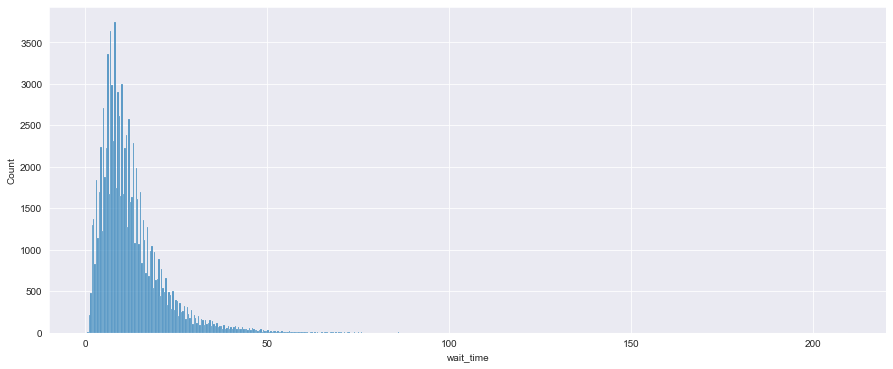

In [65]:
# 'wait_time' histogram
sns.set_style('darkgrid')
plt.figure(figsize=(15,6))
sns.histplot(orders.wait_time);

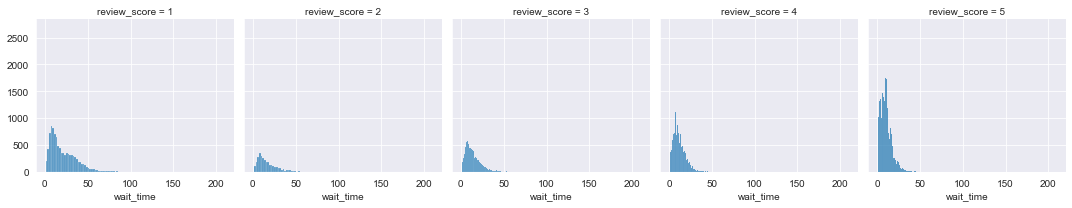

In [133]:
# Let's look at the distribution of 'wait_time' by review_score
g = sns.FacetGrid(data=orders, col='review_score')
g.map(sns.histplot, 'wait_time')
plt.show();

While the `wait_time` is generally similar across `review_score` categories, `review_score` has a larger proportion of orders with longer `wait_time`

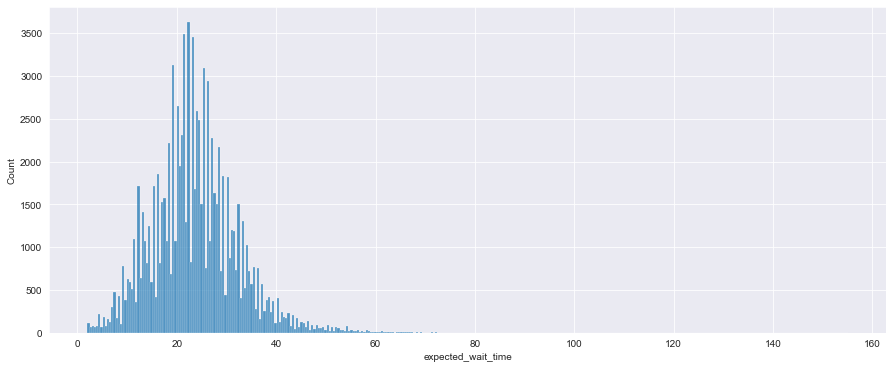

In [66]:
#'expected_wait_time' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.expected_wait_time);

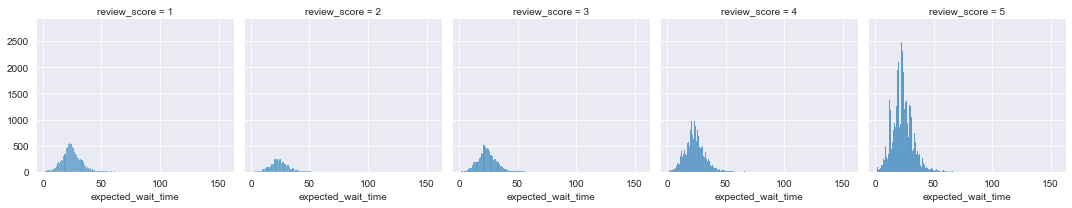

In [134]:
g1 = sns.FacetGrid(data=orders, col='review_score')
g1.map(sns.histplot, 'expected_wait_time');

It appears that generally across review scores, there's a similar distribution of expected wait times

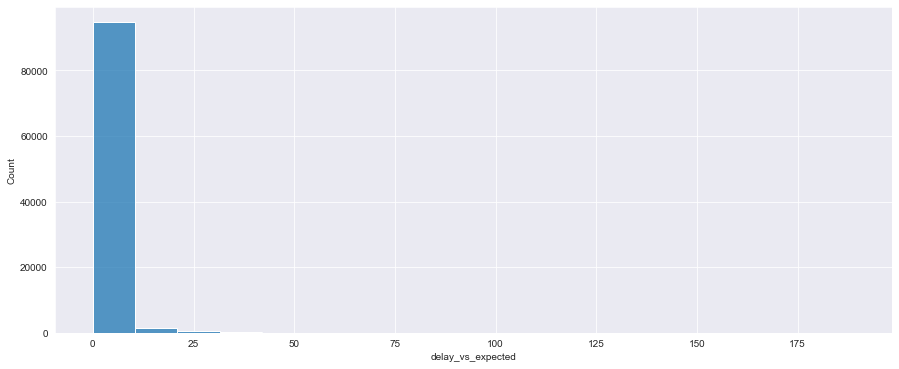

In [67]:
#'delay_vs_expected' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.delay_vs_expected);

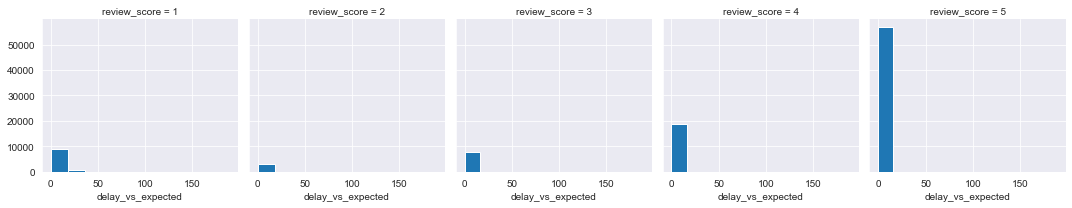

In [136]:
g2 = sns.FacetGrid(data=orders, col='review_score')
g2.map(plt.hist, 'delay_vs_expected');

Looks like few orders actually end up taking longer to receive than what customers are expecting. But, for the few orders that get delayed, roughly half belong receive a review score of 1.

In [123]:
# Number of delayed orders
orders[orders.delay_vs_expected > 0].shape[0]

7865

In [124]:
# Number of delayed orders and receiving review score of 1
orders[(orders.delay_vs_expected > 0) & (orders.review_score == 1)].shape[0] 

3671

### Distributions for `dim_is_five_star`, `dim_is_one_star`, and `review_score`

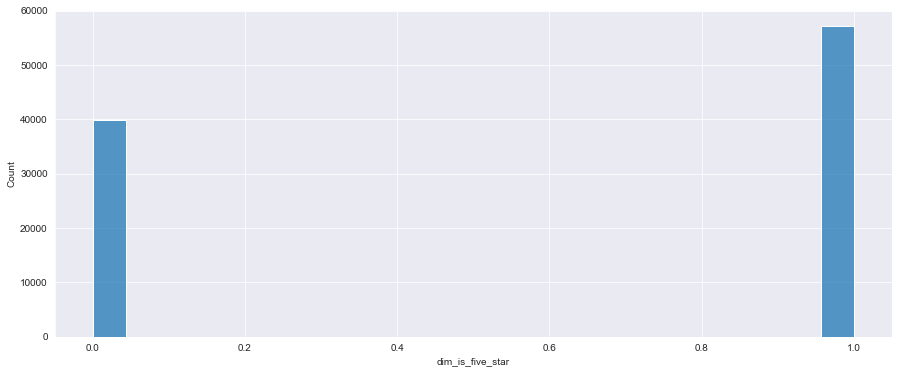

In [68]:
#'dim_is_five_star' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.dim_is_five_star);

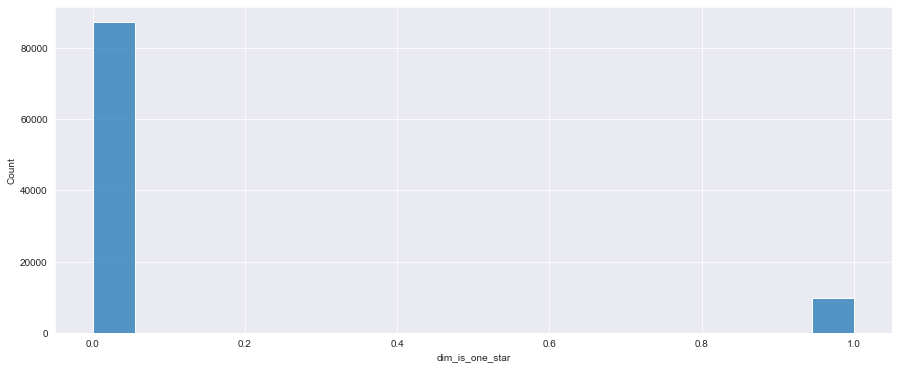

In [69]:
#'dim_is_one_star' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.dim_is_one_star);

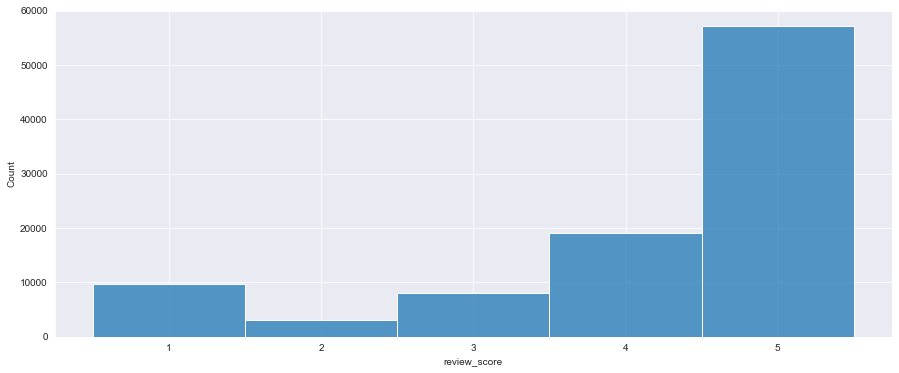

In [70]:
#'review_score' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.review_score, discrete=True);

### Distributions for `number_of_products`, `number_of_sellers`, `price`, and `freight_value`

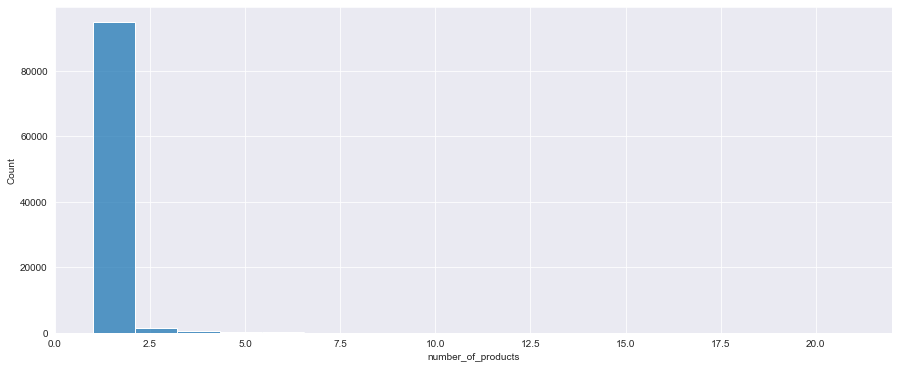

In [73]:
#'number_of_products' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.number_of_products);

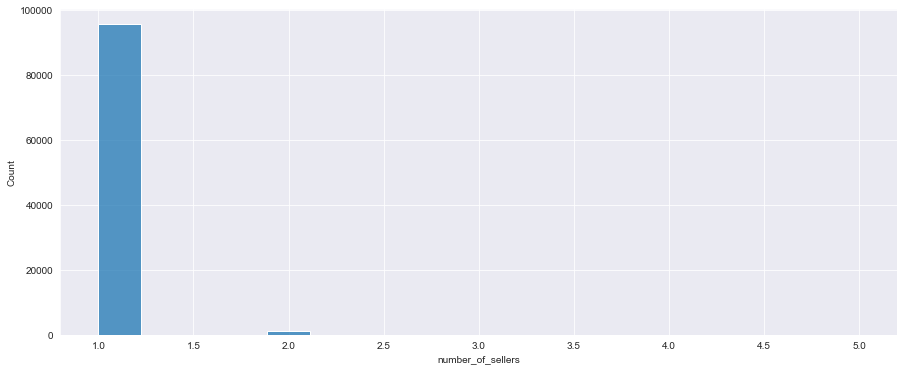

In [74]:
#'number_of_sellers' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.number_of_sellers);

Very few orders comprise more than one seller

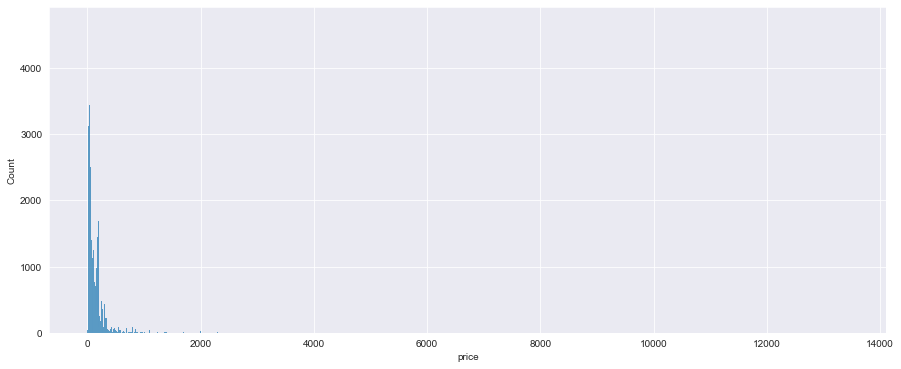

In [75]:
#'price' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.price);

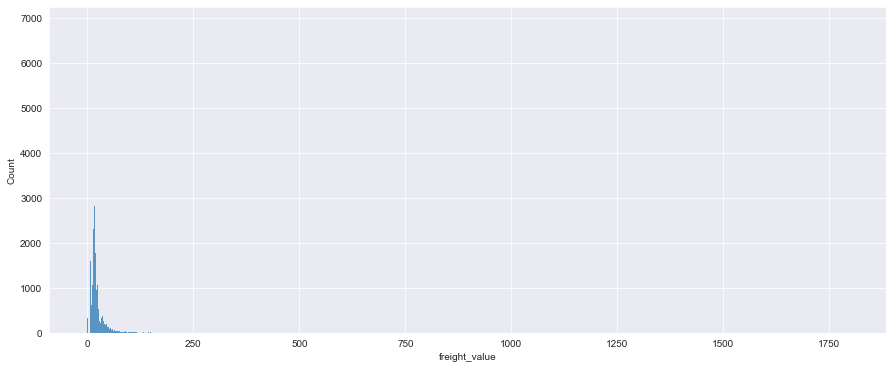

In [77]:
#'freight_value' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.freight_value);

## Correlations

Let's look to see if there are correlations between features in the orders dataset

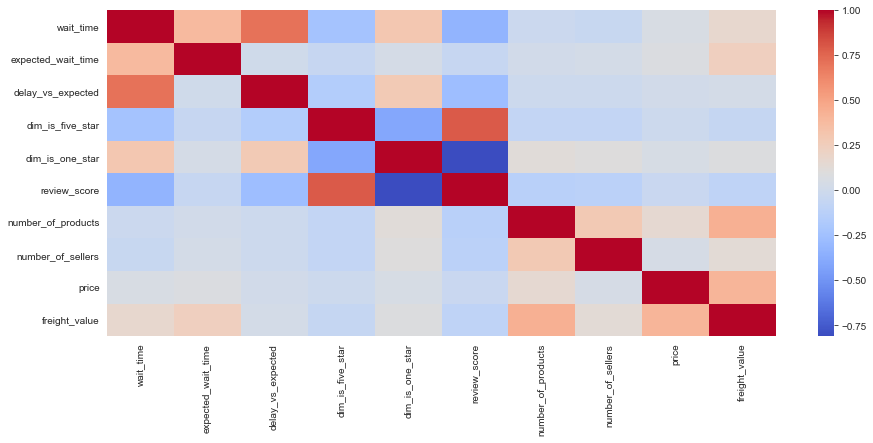

In [128]:
# Use heatmap to detect correlations with 'review_score'
plt.figure(figsize=(15,6))
sns.heatmap(orders.corr(), cmap='coolwarm');

The features `wait_time` and `delay_vs_expected` appear to have the strongest correlation with `review_score`.

In [131]:
# Let's look at the values of the correlation coefficients
orders.corr()['review_score']

wait_time            -0.334806
expected_wait_time   -0.052191
delay_vs_expected    -0.271885
dim_is_five_star      0.792079
dim_is_one_star      -0.810262
review_score          1.000000
number_of_products   -0.124405
number_of_sellers    -0.116317
price                -0.036006
freight_value        -0.091023
Name: review_score, dtype: float64

## Univariate Regression

Since the correlation coefficients for the features `wait_time` (r=33%) and `delay_vs_expected` (r=27%) have a stronger correlation with `review_score`, let's focus on them more by running a regression on them individually.  


In [138]:
import statsmodels.formula.api as smf

### Simple regression of `review_score` against `wait_time`

In [141]:
formula = 'review_score ~ wait_time'
model = smf.ols(formula=formula, data=orders).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                 1.225e+04
Date:                Sat, 07 Aug 2021   Prob (F-statistic):               0.00
Time:                        20:49:14   Log-Likelihood:            -1.5707e+05
No. Observations:               97007   AIC:                         3.142e+05
Df Residuals:                   97005   BIC:                         3.142e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7138      0.006    726.803      0.000       4.701       4.727
wait_time     -0.0455      0.000   -110.664      0.000      -0.046      -0.045
==============================================================================
Omnibus:                    19241.637   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34157.401
Skew:                          -1.282   Prob(JB):                         0.00
Kurtosis:                       4.371   Cond. No.                         26.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation**

For every additional day of wait_time, we can say with a 95% confidence level, that the review score is reduced by 0.046 on average (slope = -0.046). With a p-value close to zero, this is statistically significant and the R-squared indicates that 11% of the variance found in the review_score is attributable to `wait_time`.

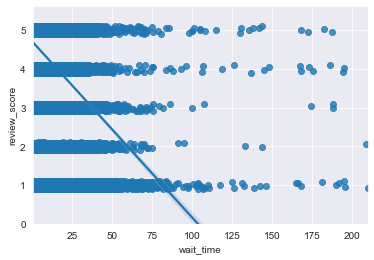

In [153]:
# Let's plot the univariate regression of 'review_score' on 'wait_time'
sns.regplot(x=orders.wait_time, y=orders.review_score, y_jitter=0.1)
plt.ylim(bottom=0);

### Simple regression of `review_score` against `delay_vs_expected`

In [150]:
formula = 'review_score ~ delay_vs_expected'
model = smf.ols(formula=formula, data=orders).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     7743.
Date:                Sat, 07 Aug 2021   Prob (F-statistic):               0.00
Time:                        21:10:48   Log-Likelihood:            -1.5912e+05
No. Observations:               97007   AIC:                         3.182e+05
Df Residuals:                   97005   BIC:                         3.183e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.1997      0.004   1034.674      0.000       4.192       4.208
delay_vs_expected    -0.0742      0.001    -87.995      0.000      -0.076      -0.073
==============================================================================
Omnibus:                    20264.119   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46233.422
Skew:                          -1.191   Prob(JB):                         0.00
Kurtosis:                       5.401   Cond. No.                         4.88
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation**

For every additional day of delay that the customer waits beyond the expected delivery date, we can say with a 95% confidence level, that the review score is reduced by 0.074 on average (slope = -0.074). With a p-value close to zero, this is statistically significant and the R-squared indicates that 7% of the variance found in the review_score is attributable to `wait_time`.

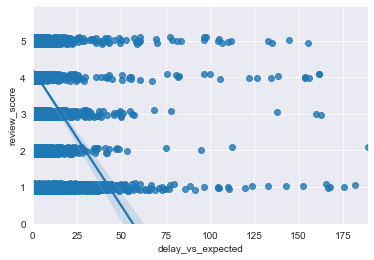

In [152]:
# Let's plot the univariate regression of 'review_score' on 'delay_vs_expected'
sns.regplot(x=orders.delay_vs_expected, y=orders.review_score, y_jitter=0.1)
plt.ylim(bottom=0);